# Plot the results of DIVAnd analysis

In [2]:
import os
import numpy as np
import glob
import cartopy.crs as ccrs
import netCDF4
import calendar
import matplotlib.pyplot as plt
import emodnetchemistry
import cartopy.feature as cfeature
import logging
coast = cfeature.GSHHSFeature(scale='h')
from importlib import reload
plt.style.use("./EMODnet.mplstyle")
reload(emodnetchemistry)

<module 'emodnetchemistry' from '/home/ctroupin/Projects/EMODnet/EMODnet-Chemistry/src/python/emodnetchemistry.py'>

In [3]:
logger = logging.getLogger("EMODnet-Chemistry-DIVAnd-Results")
logger.setLevel(logging.DEBUG)
logging.info("Starting")

### Variable

In [6]:
#varname = "phosphate"
#varname = "dissolved_inorganic_nitrogen"
# varname = "silicate"
varname = "oxygen"
# varname = "chlorophyll"

#casename = "Water_body_ammonium-res-0.25-epsilon2-10-varlen1-lb5-maxit-5000-reltol-1.0e-9-bathcl-go-exclude-mL-1960-exNS2-background"
#casename = "Water_body_chlorophyll-a-res-0.25-epsilon2-10-varlen1-lb5-maxit-5000-reltol-1.0e-9-bathcl-go-exclude-mL-1960-exNS2-background"
casename = "Water_body_dissolved_oxygen_concentration-res-0.25-epsilon2-10-varlen1-lb5-maxit-5000-reltol-1.0e-9-bathcl-go-exclude-mL-1960-exNS2-background"

if not varname in casename:
    logger.warning("Check casename!")
else:
    logger.info("Variable and directory correspond")

INFO:EMODnet-Chemistry-DIVAnd-Results:Variable and directory correspond


In [8]:
varnamedict = {
    "phosphate": {
        "stdname": "moles_of_phosphate_per_unit_mass_in_sea_water",
        "units": "µmol/l",
        "woaname": "p",
        "varmin": 0.,
        "varmax": 2.,
        "deltavar": 0.25 
    },
    "ammonium": {
        "stdname": "mole_concentration_of_ammonium_in_sea_water", 
        "units": "µmol/l",
    }, 
    "oxygen": {
        "stdname": "mole_concentration_of_dissolved_molecular_oxygen_in_sea_water", 
        "units": "µmol/l",
        "woaname": "o",
        "varmin": 200.,
        "varmax": 400.,
        "deltavar": 50.
    },
    "silicate": {
        "stdname": "mole_concentration_of_silicate_in_sea_water", 
        "units": "µmoles/l",
        "woaname": "i",
        "varmin": 0.,
        "varmax": 5.,
        "deltavar": 0.5 
    }, 
    "dissolved_inorganic_nitrogen": {
        "stdname": "mole_concentration_of_dissolved_inorganic_nitrogen_in_sea_water", 
        "units": "µmol/l",
        "varmin": 0.,
        "varmax": 10.,
        "deltavar": 1.
    },
    "chlorophyll": {
        "stdname": "mass_concentration_of_chlorophyll_in_sea_water", 
        "units": "mg/m$^3$",
        "varmin": 0.,
        "varmax": 3.,
        "deltavar": 0.5
    }
}

### Files and directories

In [16]:
resulttype = "background"
outbasedir = "/home/ctroupin/data/EMODnet-Chemistry/Eutrophication2024/Case/"
figbasedir = "/home/ctroupin/Projects/EMODnet/EMODnet-Chemistry/figures/2024/"
figdir = os.path.join(figbasedir, casename, resulttype)

outputdir = os.path.join(outbasedir, casename, "Results")
divafile = glob.glob(os.path.join(outputdir, "*.nc"))[1]
divafile

if not os.path.isdir(figdir):
    os.makedirs(figdir)
    
if not os.path.exists(divafile):
    logger.warning("DIVA file does not exist, check path")
else:
    logger.info("DIVA data file exists")
    logger.info(os.path.basename(divafile))

INFO:EMODnet-Chemistry-DIVAnd-Results:DIVA data file exists
INFO:EMODnet-Chemistry-DIVAnd-Results:Water_body_dissolved_oxygen_concentration_background.nc


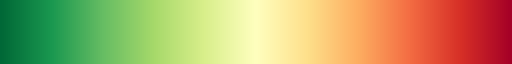

In [17]:
domain = [-45., 70., 24., 83.]
cmap=plt.cm.RdYlGn_r
cmap

### Initiate projection

In [18]:
theproj = ccrs.Mercator(central_longitude=0.5 * (domain[0] + domain[1]),
    min_latitude=domain[2], max_latitude=domain[3],globe=None)
theproj

<Projected CRS: +proj=merc +ellps=WGS84 +lon_0=12.5 +x_0=0.0 +y_0= ...>
Name: unknown
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unknown
- method: Mercator (variant A)
Datum: Unknown based on WGS 84 ellipsoid
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Monthly

In [23]:
reload(emodnetchemistry)
depthlist2plot = [0]#, 10, 50, 100, 250., 500., 750., 1500, 1000., 2000.]
for month in range(1, 12):
    mm = str(month).zfill(2)
    logger.info(f"Working on month {calendar.month_name[month]}")
       
    logger.info("Reading fields from DIVAnd")
    lon_diva, lat_diva, depth_diva, date_diva, field_diva = emodnetchemistry.read_variable_diva(divafile, 
                                                                                                domain, 
                                                                                                timeindex=month-1)
    
    llon_diva, llat_diva = np.meshgrid(lon_diva, lat_diva)
    
    # Loop on depths:   
    for depth in depthlist2plot:
        logger.info("Working on depth {} m".format(depth))            
        index2 = np.where(depth_diva == depth)[0][0]
        
        dd = str(int(depth)).zfill(4)
    
        figname = os.path.join(figdir, f"{varname}_DIVAnd_field_month_{mm}_{dd}.jpg")

        emodnetchemistry.plot_DIVAnd_field(theproj, llon_diva, llat_diva, field_diva[index2,:,:], 
                                           depth, figname=figname, varname=varname, 
                                           vmin=varnamedict[varname]["varmin"], 
                                           vmax=varnamedict[varname]["varmax"], 
                                           deltavar=varnamedict[varname]["deltavar"],
                                           units=varnamedict[varname]["units"],
                                           monthname=calendar.month_name[month],
                                           cmap=plt.cm.RdYlGn_r)

INFO:EMODnet-Chemistry-DIVAnd-Results:Working on month January
INFO:EMODnet-Chemistry-DIVAnd-Results:Reading fields from DIVAnd
INFO:EMODnet-Chemistry-Data-positions:Variable name: Water_body_dissolved_oxygen_concentration
INFO:EMODnet-Chemistry-Data-positions:Long name: Water body dissolved oxygen concentration
INFO:EMODnet-Chemistry-DIVAnd-Results:Working on depth 0 m
INFO:EMODnet-Chemistry-DIVAnd-Results:Working on month February
INFO:EMODnet-Chemistry-DIVAnd-Results:Reading fields from DIVAnd
/home/ctroupin/Projects/EMODnet/EMODnet-Chemistry/src/python/emodnetchemistry.py:311: SyntaxWarning: invalid escape sequence '\m'
  """Create a plot with the DIVAnd results (alone)
/home/ctroupin/Projects/EMODnet/EMODnet-Chemistry/src/python/emodnetchemistry.py:367: SyntaxWarning: invalid escape sequence '\m'
  """Create a plot with WOA and DIVAnd maps together


IndexError: index exceeds dimension bounds

### Background

In [25]:
reload(emodnetchemistry)
depthlist2plot = [0, 10, 50, 100, 250., 500., 750., 1500, 1000., 2000.]
       
logger.info("Reading fields from DIVAnd")
lon_diva, lat_diva, depth_diva, date_diva, field_diva = emodnetchemistry.read_variable_diva(divafile, 
                                                                                            domain, 
                                                                                            timeindex=0)
    
llon_diva, llat_diva = np.meshgrid(lon_diva, lat_diva)
    
# Loop on depths:   
for depth in depthlist2plot:
    logger.info("Working on depth {} m".format(depth))            
    index2 = np.where(depth_diva == depth)[0][0]

    dd = str(int(depth)).zfill(4)

    figname = os.path.join(figdir, f"{varname}_DIVAnd_field_background_{dd}.jpg")

    emodnetchemistry.plot_DIVAnd_field(theproj, llon_diva, llat_diva, field_diva[index2,:,:], 
                                       depth, figname=figname, varname=varname,
                                       vmin=varnamedict[varname]["varmin"], 
                                       vmax=varnamedict[varname]["varmax"], 
                                       deltavar=varnamedict[varname]["deltavar"],
                                       units=varnamedict[varname]["units"],
                                       monthname="background",
                                       cmap=plt.cm.RdYlGn_r)

/home/ctroupin/Projects/EMODnet/EMODnet-Chemistry/src/python/emodnetchemistry.py:311: SyntaxWarning: invalid escape sequence '\m'
  """Create a plot with the DIVAnd results (alone)
/home/ctroupin/Projects/EMODnet/EMODnet-Chemistry/src/python/emodnetchemistry.py:367: SyntaxWarning: invalid escape sequence '\m'
  """Create a plot with WOA and DIVAnd maps together
INFO:EMODnet-Chemistry-DIVAnd-Results:Reading fields from DIVAnd
INFO:EMODnet-Chemistry-Data-positions:Variable name: Water_body_dissolved_oxygen_concentration
INFO:EMODnet-Chemistry-Data-positions:Long name: Water body dissolved oxygen concentration
INFO:EMODnet-Chemistry-DIVAnd-Results:Working on depth 0 m
